In [2]:
%pylab nbagg
from tvb.simulator.lab import *
import tvb.analyzers.correlation_coefficient as corr_coeff
from tvb.datatypes.time_series import TimeSeriesRegion

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


# Compute functional connectivity with the corrcoef analyzer

This demo shows how to build a region time series object from simulated data and then apply an time series analyzer, corrcoef in this case, to the time series, resulting in functional connectivity.

First, we build the simulator

In [3]:
# neural mass model parameters
pars = {'a': 1.05,
        'b': -1.,
        'c': 0.0,
        'd': 0.1,
        'e': 0.0,
        'f': 1 / 3.,
        'g': 1.0,
        'alpha': 1.0,
        'beta': 0.2,
        'tau': 1.25,
        'gamma': -1.0}

# sampling frequency
sfreq = 2048.0

sim = simulator.Simulator(
    model=models.Generic2dOscillator(**pars),
    connectivity=connectivity.Connectivity(load_default=True, speed=4.0),
    coupling=coupling.Linear(a=0.033),
    integrator=integrators.HeunStochastic(dt=0.06103515625, noise=noise.Additive(nsig=numpy.array([2 ** -10, ]))),
    monitors=(monitors.TemporalAverage(period=1e3 / sfreq),
              monitors.ProgressLogger(period=2e3)),
    simulation_length=16e3
).configure()

WARNING  File 'hemispheres' not found in ZIP.


and then run it

In [4]:
(tavg_time, tavg_samples), _ = sim.run()

   INFO  step 1 time 0.0001 s
   INFO  step 32769 time 2.0001 s
   INFO  step 65537 time 4.0001 s
   INFO  step 98305 time 6.0001 s
   INFO  step 131073 time 8.0001 s
   INFO  step 163841 time 10.0001 s
   INFO  step 196609 time 12.0001 s
   INFO  step 229377 time 14.0001 s


For the analyzer, we build a time series object,

In [5]:
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=tavg_samples,
                       sample_period=sim.monitors[0].period)
tsr.configure()

and create & evaluate the analysis

In [6]:
corrcoeff_analyser = corr_coeff.CorrelationCoefficient(time_series=tsr)
corrcoeff_data = corrcoeff_analyser.evaluate()
corrcoeff_data.configure()
FC = corrcoeff_data.array_data[..., 0, 0]

   INFO  result shape will be: (76L, 76L, 1L, 1L)


and display the resulting triangular matrix

<IPython.core.display.Javascript object>


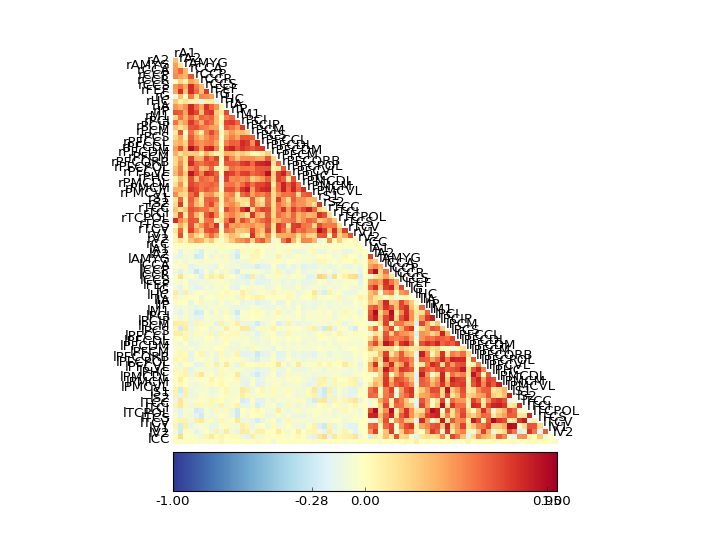

In [7]:
plot_tri_matrix(FC,
                cmap=pyplot.cm.RdYlBu_r, 
                node_labels= sim.connectivity.region_labels,
                size=[10., 10.],
                color_anchor=(-1.0, 1.0));